In [1]:
# Check that weighted cca is coherent
%pylab inline
%load_ext autoreload
%autoreload 1
%aimport new_CCA
%aimport sample_gen
from scipy.stats import multivariate_normal
from collections import defaultdict
from scipy.linalg import sqrtm

Populating the interactive namespace from numpy and matplotlib


In [2]:
def variance(x,w=None):
    if w is None:
        w = np.ones(x.shape)
    
    x_mean = (w*x).sum()/w.sum()
    
    return (w*((x-x_mean)**2)).sum()/(w.sum()-1)

def covariance(x,y,w=None):
    if w is None:
        w = np.ones(x.shape)
    
    x_mean = (w*x).sum()/w.sum()
    y_mean = (w*y).sum()/w.sum()
    
    return (w*(x-x_mean)*(y-y.mean())).sum()/(w.sum()-1)

def correlation(x,y,w=None):
    if w is None:
        w = np.ones(x.shape)
        
    return covariance(x,y,w=w)/sqrt(variance(x,w=w))/sqrt(variance(y,w=w))

# Generating test set.

$$ \newcommand{\R}{\mathbb{R}} $$

$$ X = \{ x_1, x_2, ..., x_n \mid x \in \R^k \} $$
$$ Y = \{ y_1, y_2, ..., y_n \mid y \in \R^k \} $$

$$
X = 
\begin{bmatrix}
    x_{11} && x_{12} && \dots && x_{1k} \\
    x_{21} && x_{22} && \dots && x_{2k} \\
    \vdots && \vdots && \ddots && \vdots \\
    x_{n1} && x_{n2} && \dots && x_{nk} \\
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
    y_{11} && y_{12} && \dots && y_{1k} \\
    y_{21} && y_{22} && \dots && y_{2k} \\
    \vdots && \vdots && \ddots && \vdots \\
    y_{n1} && y_{n2} && \dots && y_{nk} \\
\end{bmatrix}
$$

$$ k = 10 $$
$$ n = 1000 $$


In [3]:
k = 10
n = 1000
d1 = sample_gen.create_distribution(k,mean_std_scale=0.3,std=1)
d2 = sample_gen.create_distribution(k,mean_std_scale=1,std=2,std_scale=0.1)
X = d1.rvs(n)
Y = X+d2.rvs(n)
#w = np.abs( ( ((X-X.mean(axis=0))**2).sum(axis=1) ) )
w = abs( np.random.normal(1,0.3,size=X.shape[0]) )

# outliers
outliers_portion = 0.1
X_outliers = np.random.multivariate_normal(X.mean(axis=0), np.cov(X,rowvar=False)*10,size=int(X.shape[0]*outliers_portion))
Y_outliers = np.random.multivariate_normal(X.mean(axis=0), np.cov(X,rowvar=False)*10,size=int(X.shape[0]*outliers_portion))
outliers_weights = np.abs( np.random.normal(w.mean()*0.2,w.std()*0.5,size=X_outliers.shape[0]) )

X = np.concatenate( (X,X_outliers) )
Y = np.concatenate( (Y,Y_outliers) )
w = np.concatenate( (w,outliers_weights) )

ids = np.arange(0,X.shape[0])
np.random.shuffle(ids)
X = X[ids]
Y = Y[ids]
w = w[ids]

del d1
del d2

# Yield of CCA

$$ A \in \R^{k \times k} $$
$$ B \in \R^{k \times k} $$

$$ U = A^T X^T = \{u_1, u_2, ..., u_k\ \mid u_i = (col_iA)^T X \} $$
$$ V = B^T Y^T = \{v_1, v_2, ..., v_k\ \mid v_i = (col_iB)^T Y \} $$


# Unweighted covariance

$$\newcommand\conj[1]{\bar{#1}}$$
$$\newcommand\mean[1]{\bar{#1}}$$

$$ \sum_i^n (x_i-\mean x)(y_i-\mean y) $$
$$ \sum_i^n [ x_i y_i -x_i \mean y -y_i \mean x + \mean x \mean y ] $$
$$ \sum_i^n x_i y_i - \mean y \sum_i^n x_i - \mean x \sum_i^n y_i + n \mean x \mean y $$
$$ \sum_i^n x_i y_i - n \mean y \mean x - n \mean x \mean y + n \mean x \mean y $$
$$ \sum_i^n x_i y_i - n \mean y \mean x $$

# Weighted covariance

$$\newcommand\mean[1]{\bar{#1}}$$

$$ \sum_i^n w_i(x_i-\mean x)(y_i-\mean y) $$
$$ \sum_i^n [ w_i x_i y_i - w_i x_i \mean y - w_i y_i \mean x + w_i \mean x \mean y ] $$
$$ \sum_i^n w_i x_i y_i - \mean y \sum_i^n w_i x_i - \mean x \sum_i^n w_i y_i + \mean x \mean y \sum_i^n w_i $$
$$ \sum_i^n w_i x_i y_i - \mean y \mean x \sum w_i - \mean x \mean y \sum w_i + \mean x \mean y \sum_i^n w_i $$
$$ \sum_i^n w_i x_i y_i - \mean x \mean y \sum_i^n w_i $$

## Generally

$$\newcommand\mean[1]{\bar{#1}}$$
$$\newcommand\vectorof[1]{\overrightarrow{#1}}$$

$$ X^T W Y - X^T w \mean{Y}^T - \mean{X} w^T Y + \mean{X} \mean{Y}^T \mean{w}n $$

In [15]:
# weighted
cca = new_CCA.CCA(k)
cca.push(X,Y,w=w)
A,B, reg = cca.calc()
U = A.T @ X.T
V = B.T @ Y.T

In [9]:
# standard
cca = new_CCA.CCA(k)
cca.push(X,Y)
A,B, reg = cca.calc()
U = A.T @ X.T
V = B.T @ Y.T

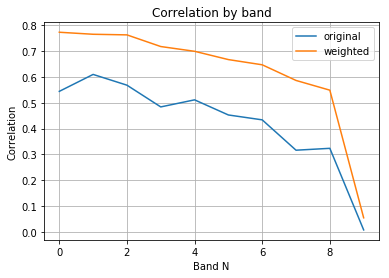

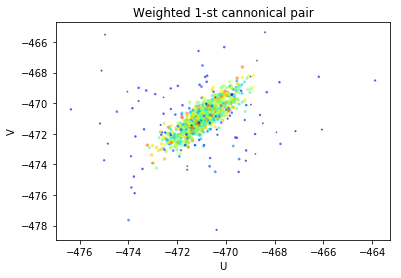

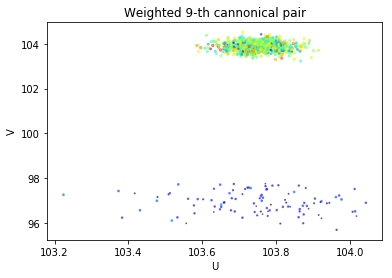

In [16]:
title("Correlation by band")
plot( np.array( [abs(correlation(U[i],V[i])) for i in range(k)] ), label='original');
plot( np.array( [abs(correlation(U[i],V[i],w=w)) for i in range(k)] ), label='weighted');
xlabel("Band N")
ylabel("Correlation");
legend();
grid();
show();

title("Weighted 1-st cannonical pair")
scatter( (U+reg[:,0,np.newaxis])[0], V[0],  s=sqrt(w)*5, c=w,alpha=0.5,cmap='jet');
xlabel("U");
ylabel("V")
show();
title("Weighted 9-th cannonical pair")
scatter( (U+reg[:,0,np.newaxis])[9], V[9],  s=sqrt(w)*5, c=w,alpha=0.5,cmap='jet');
xlabel("U");
ylabel("V")
show();